## Imports and Helper Functions

In [1]:
import os
import glob
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import sounddevice as sd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import tensorflow as tf
from keras.models import load_model

2025-04-28 23:24:22.933932: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-28 23:24:22.947685: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-28 23:24:22.952083: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-28 23:24:22.962413: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## **1 System Configuration**

In [2]:
import warnings
warnings.filterwarnings("ignore") # Filters out warnings when running notebook cells

In [3]:
import sys

# Adds this notebooks current directory to project path
# This is necessary due to issues with calling functions from src.utils
project_path = os.path.abspath('.')
if project_path not in sys.path:
    sys.path.append(project_path) 

In [4]:
# Check if current run is using GPU or not
gpu_devices = tf.config.list_physical_devices('GPU')
if len(gpu_devices) > 0:
    print('Using GPU')
else:
    print('Not Using GPU')

Using GPU


I0000 00:00:1745897064.281941   33328 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1745897064.327694   33328 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1745897064.327946   33328 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


In [5]:
print(tf.__version__)

2.17.0


## **2 Import Dataset**

#### Emotion mapping: convert emotion code (string) to integer label (0-based)

In [6]:
# Determines path to each class folder
dataset_path = os.path.join(project_path, 'dataset')

instrument_labels = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]

print(f'Number of classes: {len(instrument_labels)}')
print(instrument_labels)

Number of classes: 28
['Tambourine', 'Clarinet', 'cowbell', 'Trombone', 'Floor_Tom', 'vibraphone', 'Electro_Guitar', 'Horn', 'Saxophone', 'flute', 'Trumpet', 'Violin', 'Harmonium', 'Dobro', 'Shakers', 'Keyboard', 'Mandolin', 'Hi_Hats', 'Organ', 'Accordion', 'Banjo', 'Drum_set', 'Cymbals', 'Bass_Guitar', 'Acoustic_Guitar', 'Harmonica', 'Piano', 'Ukulele']


In [7]:
instrument_map = {instrument_name: index for index , instrument_name in enumerate(instrument_labels)}
print(instrument_map)

{'Tambourine': 0, 'Clarinet': 1, 'cowbell': 2, 'Trombone': 3, 'Floor_Tom': 4, 'vibraphone': 5, 'Electro_Guitar': 6, 'Horn': 7, 'Saxophone': 8, 'flute': 9, 'Trumpet': 10, 'Violin': 11, 'Harmonium': 12, 'Dobro': 13, 'Shakers': 14, 'Keyboard': 15, 'Mandolin': 16, 'Hi_Hats': 17, 'Organ': 18, 'Accordion': 19, 'Banjo': 20, 'Drum_set': 21, 'Cymbals': 22, 'Bass_Guitar': 23, 'Acoustic_Guitar': 24, 'Harmonica': 25, 'Piano': 26, 'Ukulele': 27}


#### Function to extract statistical MFCC features (for Random Forest)

In [8]:
def extract_statistical_features(file_path, n_mfcc=13):
    try:
        y, sr = librosa.load(file_path, sr=None)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        mfcc_delta = librosa.feature.delta(mfcc)
        mfcc_delta2 = librosa.feature.delta(mfcc, order=2)
        mfcc_mean = np.mean(mfcc, axis=1)
        mfcc_std = np.std(mfcc, axis=1)
        delta_mean = np.mean(mfcc_delta, axis=1)
        delta_std = np.std(mfcc_delta, axis=1)
        delta2_mean = np.mean(mfcc_delta2, axis=1)
        delta2_std = np.std(mfcc_delta2, axis=1)
        features = np.concatenate([mfcc_mean, mfcc_std, delta_mean, delta_std, delta2_mean, delta2_std])
        return features, y, sr, mfcc
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None, None, None, None

#### Function to extract fixed-size MFCC image for CNN

In [9]:
def get_mfcc_image(file_path, n_mfcc=13, max_len=216):
    try:
        y, sr = librosa.load(file_path, sr=None)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        # Pad or truncate the MFCC to have a fixed number of frames (max_len)
        mfcc_fixed = librosa.util.fix_length(mfcc, size=max_len, axis=1)
        return mfcc_fixed
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

## Load Dataset and Extract Features

#### Define dataset path and recursively get all .wav files from the dataset

In [10]:
audio_files = glob.glob(os.path.join(project_path, 'dataset', '**', '*.wav'), recursive=True)

assert len(audio_files) > 0, "Audio files not found"

print("Number of audio files found:", len(audio_files))


Number of audio files found: 42311


#### Initialize lists for features and labels

In [11]:
features_list = []
labels_list = []
waveforms = []   # For visualization
sample_rates = []  # For visualization
mfccs = []       # For visualization
file_names = []  # To store file paths

# For CNN images
cnn_images = []


#### Process each audio file

In [12]:
file_path = audio_files[0]
dir_path = os.path.dirname(file_path)
dir_name = os.path.basename(dir_path)
print(dir_name)

Tambourine


In [13]:
for file_path in audio_files:
    # Extract statistical features for Random Forest
    features, y, sr, mfcc = extract_statistical_features(file_path, n_mfcc=13)
    if features is not None:
        features_list.append(features)
        waveforms.append(y)
        sample_rates.append(sr)
        mfccs.append(mfcc)
        file_names.append(file_path)
        
        # Parse the filename
        dir_path = os.path.dirname(file_path)
        dir_name = os.path.basename(dir_path)
        labels_list.append(dir_name)
        
        # Extract MFCC image for CNN classifier
        mfcc_img = get_mfcc_image(file_path, n_mfcc=13, max_len=216)
        if mfcc_img is not None:
            cnn_images.append(mfcc_img)

#### Convert lists to numpy arrays

In [14]:
features_array = np.array(features_list)
labels_array = np.array(labels_list)
cnn_images = np.array(cnn_images)

print("Features array shape (Random Forest):", features_array.shape)
print("Labels array shape:", labels_array.shape)
print("CNN images shape:", cnn_images.shape)  # Expected shape: (num_samples, 13, 216)

Features array shape (Random Forest): (42311, 78)
Labels array shape: (42311,)
CNN images shape: (42311, 13, 216)


## Visualize an Example Audio File and its MFCC Heatmap

#### Plot the audio waveform

In [15]:
# CODE
example_index = 0
y_example = waveforms[example_index]
sr_example = sample_rates[example_index]
mfcc_example = mfccs[example_index]

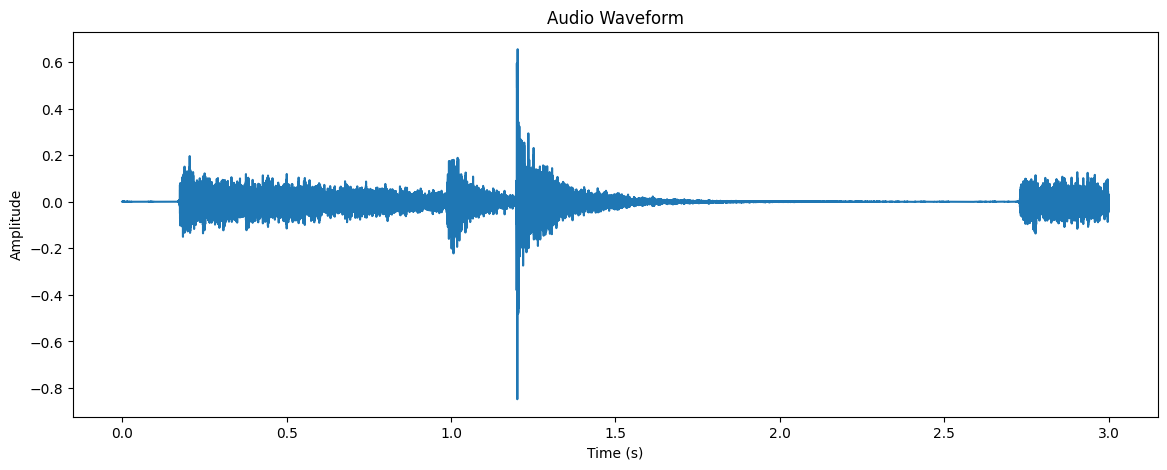

In [16]:
# CODE
# Create a time vector in seconds
t = np.linspace(0, len(y_example) / sr_example, num=len(y_example))

plt.figure(figsize=(14, 5))
plt.plot(t, y_example)
plt.title("Audio Waveform")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

#### Plot the MFCC heatmap using imshow (as an alternative to specshow)

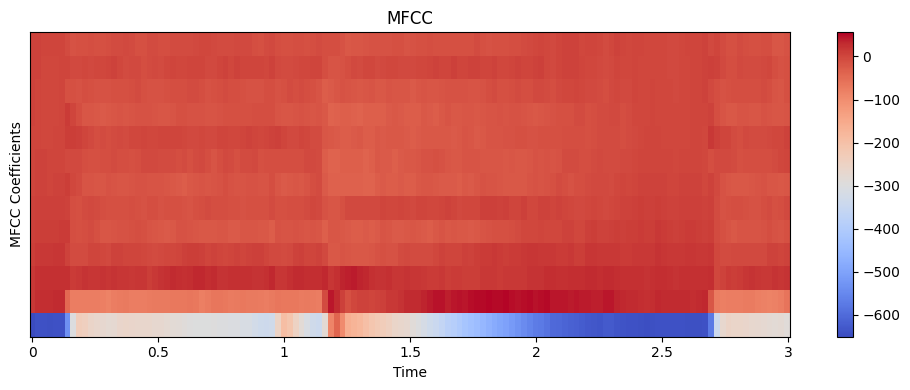

In [17]:
# CODE
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfcc_example, x_axis='time')
plt.colorbar()
plt.title("MFCC")
plt.xlabel("Time")
plt.ylabel("MFCC Coefficients")
plt.tight_layout()
plt.show()

## Random Forest classifier

#### Train-Test Split

In [18]:
# CODE
X_train, X_test, y_train, y_test = train_test_split(features_array, labels_array, test_size=0.2, random_state=42, stratify=labels_array)

#### Train a Random Forest classifier

In [19]:
# CODE
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

#### Evaluate on the test set

In [20]:
# CODE
y_pred_rf = rf_clf.predict(X_test)
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))

Random Forest Classification Report:
                 precision    recall  f1-score   support

      Accordion       0.91      0.99      0.95       716
Acoustic_Guitar       0.92      0.99      0.96       731
          Banjo       0.97      0.99      0.98       600
    Bass_Guitar       1.00      1.00      1.00       723
       Clarinet       0.96      0.91      0.93       127
        Cymbals       0.94      0.73      0.82        41
          Dobro       1.00      0.67      0.80        97
       Drum_set       1.00      1.00      1.00       730
 Electro_Guitar       0.98      0.93      0.95       263
      Floor_Tom       0.90      0.98      0.93        81
      Harmonica       1.00      0.73      0.84        26
      Harmonium       1.00      1.00      1.00       263
        Hi_Hats       0.90      0.85      0.88        89
           Horn       1.00      1.00      1.00       252
       Keyboard       1.00      1.00      1.00       408
       Mandolin       0.95      0.91      0.93    

#### Plot the confusion matrix

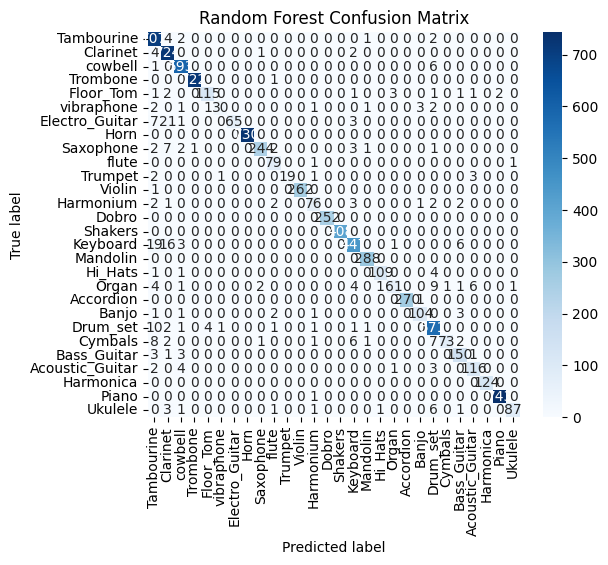

In [21]:
# CODE
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6,5))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues", xticklabels=instrument_labels, yticklabels=instrument_labels)
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.title("Random Forest Confusion Matrix")
plt.show()

In [22]:
# Create models directory if it doesn't exist
models_dir = os.path.join(project_path, 'models')
os.makedirs(models_dir, exist_ok=True)

# Save the rf model
joblib.dump(rf_clf, os.path.join(project_path, 'models/random_forest_model.pkl'))

['/home/guichard/Course/Music-Final-Project/models/random_forest_model.pkl']

## Prepare Data and Train the CNN Classifier

#### Expand dimensions of CNN images to add a channel dimension (required by CNNs)

In [23]:
# cnn_images_exp = cnn_images[..., np.newaxis]  # New shape: (num_samples, 13, 216, 1)
cnn_images_exp = np.expand_dims(cnn_images, axis=-1)
assert len(cnn_images.shape) == 3, "dimension error?"

print(cnn_images_exp.shape)

(42311, 13, 216, 1)


#### Split data for the CNN classifier

In [24]:
num_label = [instrument_map.get(instrument) for instrument in labels_array]
print(np.unique(num_label))
print(instrument_map)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27]
{'Tambourine': 0, 'Clarinet': 1, 'cowbell': 2, 'Trombone': 3, 'Floor_Tom': 4, 'vibraphone': 5, 'Electro_Guitar': 6, 'Horn': 7, 'Saxophone': 8, 'flute': 9, 'Trumpet': 10, 'Violin': 11, 'Harmonium': 12, 'Dobro': 13, 'Shakers': 14, 'Keyboard': 15, 'Mandolin': 16, 'Hi_Hats': 17, 'Organ': 18, 'Accordion': 19, 'Banjo': 20, 'Drum_set': 21, 'Cymbals': 22, 'Bass_Guitar': 23, 'Acoustic_Guitar': 24, 'Harmonica': 25, 'Piano': 26, 'Ukulele': 27}


In [25]:
# CODE
X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn = train_test_split(cnn_images_exp, num_label, test_size=0.2, random_state=42, stratify=num_label)

In [26]:
import tensorflow as tf

y_train_cnn = tf.one_hot(y_train_cnn, len(instrument_labels))
y_test_cnn = tf.one_hot(y_test_cnn, len(instrument_labels))

I0000 00:00:1745897491.398742   33328 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1745897491.399304   33328 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1745897491.399574   33328 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1745897491.477946   33328 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

#### Build the CNN model for multi-class classification

In [27]:
input_shape = X_train_cnn[0].shape
num_classes = len(instrument_labels)
print(f'input shape:{input_shape}\nnumber of classes:{num_classes}')

input shape:(13, 216, 1)
number of classes:28


In [28]:
from src.model import get_model

model = get_model(input_shape=input_shape, num_classes=num_classes, print_summary=True)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 11, 214, 128)   │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 11, 214, 128)   │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 9, 212, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 9, 212, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 210, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 7, 210, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 5, 208, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 5, 208, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 3, 206, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 3, 206, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 158208)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    81,003,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 28)             │         7,196 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 83,212,828 (317.43 MB)

 Trainable params: 83,210,524 (317.42 MB)

 Non-trainable params: 2,304 (9.00 KB)

In [29]:
# CODE
from keras.callbacks import EarlyStopping, ModelCheckpoint
callback = EarlyStopping(monitor='val_loss', patience=4)

# Save the epoch with the lowest loss
checkpoint = ModelCheckpoint(os.path.join(project_path, 'models/model.keras'), monitor='val_loss', save_best_only=True, mode='min', verbose=1)

#### Compile the model

In [30]:
# CODE
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['categorical_accuracy']),

(None,)

#### Train the CNN model

In [ ]:
# CODE
history = model.fit(X_train_cnn, y_train_cnn, epochs=100, batch_size=32, validation_split=0.2, callbacks=[callback, checkpoint])

Epoch 1/100


I0000 00:00:1745897495.275663   36892 service.cc:146] XLA service 0x77741c0046e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745897495.275689   36892 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Ti, Compute Capability 8.6
2025-04-28 23:31:35.363470: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-04-28 23:31:35.650510: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90101
2025-04-28 23:31:37.284650: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2204', 36 bytes spill stores, 40 bytes spill loads

2025-04-28 23:31:37.613180: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in fu

  2/847 ━━━━━━━━━━━━━━━━━━━━ 58s 69ms/step - categorical_accuracy: 0.0391 - loss: 10.6846      

I0000 00:00:1745897508.612290   36892 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


846/847 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - categorical_accuracy: 0.6028 - loss: 7.2607

2025-04-28 23:32:44.456795: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1650', 8 bytes spill stores, 8 bytes spill loads

2025-04-28 23:32:46.747767: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 16.15GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-04-28 23:32:47.225537: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 32.27GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


847/847 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - categorical_accuracy: 0.6030 - loss: 7.2550
Epoch 1: val_loss improved from inf to 0.60798, saving model to /home/guichard/Course/Music-Final-Project/models/model.keras
847/847 ━━━━━━━━━━━━━━━━━━━━ 89s 87ms/step - categorical_accuracy: 0.6031 - loss: 7.2494 - val_categorical_accuracy: 0.8352 - val_loss: 0.6080
Epoch 2/100
846/847 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - categorical_accuracy: 0.8507 - loss: 0.5297
Epoch 2: val_loss improved from 0.60798 to 0.36046, saving model to /home/guichard/Course/Music-Final-Project/models/model.keras
847/847 ━━━━━━━━━━━━━━━━━━━━ 60s 71ms/step - categorical_accuracy: 0.8507 - loss: 0.5297 - val_categorical_accuracy: 0.8880 - val_loss: 0.3605
Epoch 3/100
846/847 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - categorical_accuracy: 0.8530 - loss: 0.5795
Epoch 3: val_loss improved from 0.36046 to 0.28504, saving model to /home/guichard/Course/Music-Final-Project/models/model.keras
847/847 ━━━━━━━━━━━━━━━━━━━━ 60s 71ms/step 

#### Evaluate the CNN model on the test set

In [ ]:
# CODE
cnn_eval = model.evaluate(X_test_cnn, y_test_cnn, verbose=0)
print("CNN Test Loss: {:.4f}, Test Accuracy: {:.4f}".format(cnn_eval[0], cnn_eval[1]))

In [ ]:
from src.utils import plot_results

In [ ]:
# Retrieve training results.
train_loss = history.history["loss"]
train_acc  = history.history["categorical_accuracy"]
valid_loss = history.history["val_loss"]
valid_acc  = history.history["val_categorical_accuracy"]
    
plot_results([ train_acc, valid_acc ], 
            ylabel="Accuracy",
            metric_name=["Training Accuracy", "Validation Accuracy"],
            color=["b", "g"])

plot_results([ train_loss, valid_loss ],        
            ylabel="Loss", 
            metric_name=["Training Loss", "Validation Loss"],
            color=["b", "g"]);

## Save the Trained Models

In [ ]:
# CODE
# cnn_model.save('models/cnn_model.keras') Dont need to do this as we already saved the best model

## Load the saved models

In [ ]:
# CODE
loaded_cnn_model = load_model(os.path.join(project_path, 'models/model.keras'))

## Inference on a New Audio File or via Microphone Recording

In [ ]:
# Set source = 'file' to use an external audio file (e.g., 'new_audio.wav')
# Set source = 'mic' to record audio from the microphone

source = 'file'  # Change to 'file' if you want to use an external file

if source == 'file':
    # Inference using an external audio file
    new_audio_path = 'trumpet_test.wav'  # Provide the path to your audio file
    
    # Extract features for the Random Forest model
    features_new, y_new, sr_new, mfcc_new = extract_statistical_features(new_audio_path, n_mfcc=13)
    if features_new is not None:
        features_new = features_new.reshape(1, -1)
    
    # Extract MFCC image for the CNN model
    mfcc_img_new = get_mfcc_image(new_audio_path, n_mfcc=13, max_len=216)
    if mfcc_img_new is not None:
        mfcc_img_new = mfcc_img_new[np.newaxis, ..., np.newaxis]

elif source == 'mic':
    duration = 3  # seconds to record
    fs = 48000   # Sampling rate
    print(f"Recording audio for {duration} seconds...")
    recording = sd.rec(int(duration * fs), samplerate=fs, channels=1, dtype='float32')
    sd.wait() 
    y_new = recording.flatten()  
    sr_new = fs
    print("Recording complete.")

    mfcc_record = librosa.feature.mfcc(y=y_new, sr=sr_new, n_mfcc=13)
    mfcc_delta = librosa.feature.delta(mfcc_record)
    mfcc_delta2 = librosa.feature.delta(mfcc_record, order=2)
    mfcc_mean = np.mean(mfcc_record, axis=1)
    mfcc_std = np.std(mfcc_record, axis=1)
    delta_mean = np.mean(mfcc_delta, axis=1)
    delta_std = np.std(mfcc_delta, axis=1)
    delta2_mean = np.mean(mfcc_delta2, axis=1)
    delta2_std = np.std(mfcc_delta2, axis=1)
    
    # Concatenate statistical features for Random Forest prediction
    features_new = np.concatenate([mfcc_mean, mfcc_std, delta_mean, delta_std, delta2_mean, delta2_std]).reshape(1, -1)

    
    # For the CNN model, create a fixed-size MFCC image
    max_len = 216
    mfcc_img_new = librosa.util.fix_length(mfcc_record, size=max_len, axis=1)
    mfcc_img_new = mfcc_img_new[np.newaxis, ..., np.newaxis]
else:
    raise ValueError("Invalid source selected. Please set source to 'file' or 'mic'.")

#### Make predictions using the trained models

In [ ]:
rf_pred_new = rf_clf.predict(features_new)[0]
cnn_pred_probs_new = model.predict(mfcc_img_new)[0]
cnn_pred_new = np.argmax(cnn_pred_probs_new)

In [ ]:
print("Random Forest Prediction:", rf_pred_new)
print("CNN Prediction:", instrument_labels[cnn_pred_new])